In [1]:
import kagglehub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

In this notebook we will train a convolutional architecture in Pytorch to label brain MRI images with a type of malignancy of types:

glioma - meningioma - notumor - pituitary

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
from typing import List, Tuple

from dataclasses import dataclass
import matplotlib.pyplot as plt
import random
import time

Not all images have the same size. We resize to 512 x 512 resolution

In [3]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir: str, transform: transforms.Compose = None, target_size: Tuple[int, int] = (512, 512)):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size  
        
        self._X: List[torch.Tensor] = []
        self._y: List[int] = []
        self.image_paths: List[str] = [] 
        self.label_map = {
            'glioma': 0,
            'meningioma': 1,
            'notumor': 2,
            'pituitary': 3
        }
        self.label_map_inv = {v: k for k, v in self.label_map.items()}
        
        self.basic_transform = transforms.Compose([
            transforms.Resize(self.target_size, interpolation=transforms.InterpolationMode.LANCZOS),
            transforms.ToTensor(),
        ])
        
        # Load data into memory
        self._load_data()
    
    def _load_data(self):
        """Loads and preprocesses the dataset."""
        for class_name, label in self.label_map.items():
            class_folder = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_folder):
                for filename in os.listdir(class_folder):
                    image_path = os.path.join(class_folder, filename)
                    if os.path.isfile(image_path):
                        try:
                            image = Image.open(image_path).convert('RGB')
                            
                            image_tensor = self.basic_transform(image)
                            
                            # Verify tensor size
                            expected_shape = (3, *self.target_size)
                            if image_tensor.shape != expected_shape:
                                print(f"Error: Tensor shape is {image_tensor.shape}, expected {expected_shape}")
                                continue
                            
                            self._X.append(image_tensor)
                            self._y.append(label)
                            self.image_paths.append(image_path)
                            
                        except Exception as e:
                            print(f"Error processing {image_path}: {str(e)}")
    
    def __len__(self):
        """Returns the number of images in the dataset."""
        return len(self._X)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """Returns a single image tensor and its corresponding label."""
        image_tensor = self._X[idx]
        label = self._y[idx]
        
        if self.transform:
            image_tensor = self.transform(image_tensor)
        
        return image_tensor, label

    def plot_random_images(self, num_images=4, figsize=(12, 3)):
        """Plot a random sample of images with their labels."""
        fig, axes = plt.subplots(1, num_images, figsize=figsize)
        random_indices = random.sample(range(len(self)), num_images)
        
        for i, idx in enumerate(random_indices):
            image_tensor = self._X[idx] 
            label = self._y[idx]
            
            image_array = image_tensor.permute(1, 2, 0).numpy().clip(0, 1)
            
            ax = axes[i]
            ax.imshow(image_array)
            ax.set_title(f"Label: {self.label_map_inv[label]}")
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

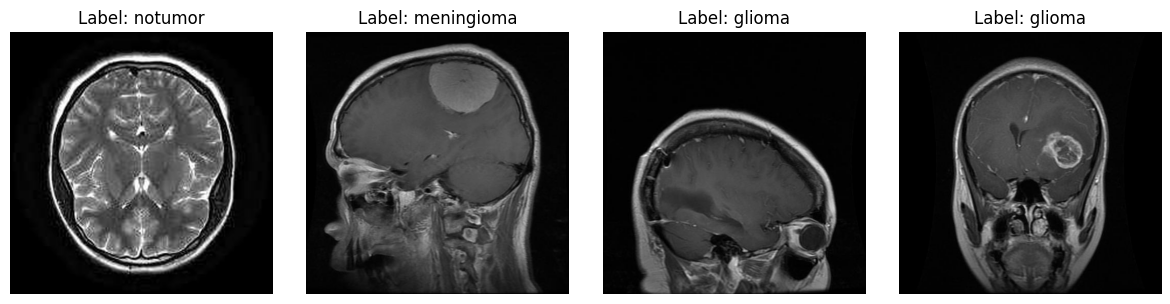

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train = BrainTumorDataset(root_dir='data/brain-tumor-mri-dataset/training', transform=train_transform)
test = BrainTumorDataset(root_dir='data/brain-tumor-mri-dataset/testing', transform=train_transform)

train_loader = DataLoader(dataset=train, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=1, shuffle=True)

train.plot_random_images(num_images=4)

In [5]:
class BrainTumorClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=2),    # 512 -> 254
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=5, stride=5),   # 254 -> 50
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=5, stride=5),   # 50 -> 10
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=5, stride=2),   # 10 -> 3
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16 * 3 * 3, 4)
        )
    
    def forward(self, x):
        return self.model(x)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainTumorClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
num_epochs = 40

Functionality below can be made part of the model class

In [ ]:
for epoch in range(num_epochs):
    starting_time = time.time()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    correct = 0 # For testing
    
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions

    # Adding the test accuracy (at the cost of computational speed)
    with torch.no_grad(): # prevents computing gradients and therefore interfering with the backpropagation
        for inputs, labels in test_loader:
            outputs = model(inputs)
            # _, predicted = torch.max(outputs, 1) == labels
            correct += (torch.argmax(outputs, 1) == labels).sum().item()
        test_accuracy = correct / len(test._y)
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Test accuracy: {test_accuracy:.4f}, Computation time (min): {(time.time() - starting_time)/60:.1f}")

Epoch [1/40], Loss: 0.6773, Accuracy: 0.7334, Test accuracy: 0.7551, Computation time (min): 3.4
Epoch [2/40], Loss: 0.4436, Accuracy: 0.8298, Test accuracy: 0.8177, Computation time (min): 3.3
Epoch [3/40], Loss: 0.3546, Accuracy: 0.8708, Test accuracy: 0.8482, Computation time (min): 3.2
Epoch [4/40], Loss: 0.3044, Accuracy: 0.8890, Test accuracy: 0.8452, Computation time (min): 3.2
Epoch [5/40], Loss: 0.2576, Accuracy: 0.9027, Test accuracy: 0.8924, Computation time (min): 3.5
Epoch [6/40], Loss: 0.2218, Accuracy: 0.9182, Test accuracy: 0.8947, Computation time (min): 3.3
Epoch [7/40], Loss: 0.1866, Accuracy: 0.9326, Test accuracy: 0.8932, Computation time (min): 3.3
Epoch [8/40], Loss: 0.1664, Accuracy: 0.9401, Test accuracy: 0.8848, Computation time (min): 3.0


We obtain surprisingly good results given that the neural network is very easy. Some questions remain:
1. What do the kernels look like? What would they look like is we, for example start off with more channels and a larger kernel size?
2. Can we spot which tumors are predicted well or bad? 

Below we see the confusion matrix of the prediction of the simple model. We observe [....]

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report

true_labels = torch.tensor()
predicted_labels = torch.tensor()

with torch.no_grad(): # prevents computing gradients and therefore interfering with the backpropagation
    for inputs, labels in test_loader:
        outputs = model(inputs)
        true_labels.append(labels)
        predicted_labels.append(torch.argmax(outputs, 1))

    predicted_labels = predicted_labels.numpy()
    true_labels = true_labels.numpy()
    multilabel_confusion_matrix(true_labels, predicted_labels)
            

Below we visualize the kernels of the first convolutional layer.

In [ ]:
model.eval()

def plot_kernels(kernels, n_cols=6):
    n_kernels = kernels.shape[0]
    n_rows = (n_kernels + n_cols - 1) // n_cols  # Calculate number of rows needed
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
    
    for i in range(n_kernels):
        ax = axes[i // n_cols, i % n_cols]
        kernel = kernels[i, 0, :, :]  # Assume single channel input
        ax.imshow(kernel, cmap='gray')
        ax.axis('off')
    
    # Hide any empty subplots
    for i in range(n_kernels, n_rows * n_cols):
        axes[i // n_cols, i % n_cols].axis('off')
    
    plt.show()

# Call the function to plot the kernels
plot_kernels(model.model[0].weight.detach().numpy(), n_cols=4)

In [ ]:
classification_report(true_labels, predicted_labels) # Should add target_names, we need to figure out how to do this

[Old text]
The problem of detecting (the type of) tumor may be rather complex for a computer. In a regular MRI photo, many features are shown, such as the folds in the brain, eyes, facial features, etc. It has to distinguish these from a tumor. Due to this complexity, a deeper neural network is expected. As seen as above, even a very simple network yield great result. We will explore what results van be reached with more complex models. Deeper networks pair with vanishing and exploding gradients, therefore, we will use batch normalisation and residual layers.

We will do two different options:
1. As above, define a model with more layers and complexities.
2. Use a pretrained model (Inception-V3 for example), and add some layers to it and train those (training the original network is next to impossible on a CPU)

For the second option one needs to notice that many pretrained networks are designed for lower pixel dimensions, mostly 224 x 224. Hence we need to resize the data to that dimension.

We start off by option 1.

Something is off in this network. It does not seem to train.

Lets make our own network. We start off by building a c

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ConvBlock, self).__init__()

        self.convblock = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=kernel_size//2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=kernel_size//2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.relu(self.conv(x))
    
class BrainTumorClassifier2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            ConvBlock(3, 16, 5),   # Input: 224, output = floor(((224 + 2 - 1*(5-1) - 1) / 2 + 1) = 111 -> ... 55
            ConvBlock(16, 16, 4),  # Input: 111, output = floor(((55 + 2 - 1*(5-1) - 1) / 2 + 1) = 27 -> 13
            ConvBlock(16, 16, 3),  # Input: 111, output = floor(((55 + 2 - 1*(5-1) - 1) / 2 + 1) = 7 -> 4 
            
            nn.AdaptiveAvgPool2d((1, 1)),

            nn.Flatten(),
            nn.Linear(256, 4)
        )
    
    def forward(self, x):
        return self.model(x)

In [ ]:
class BrainTumorClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        in_features = self.model.fc.in_features

        # Freezing all weights of resnet18
        for param in self.model.parameters():
            param.requires_grad = False
        
        # self.classifier = nn.Sequential(
        #     nn.Linear(in_features, 128),
        #     nn.ReLU(),
        #     nn.Linear(128, 32),
        #     nn.ReLU(),
        #     nn.Linear(32, 4)
        # )

        self.classifier = nn.Sequential( # Test with a very simple added sequence of layers, see how fast this is.
            nn.Identity(),
            nn.ReLU(),
            nn.Linear(in_features, 4)
        )
    
    def forward(self, x):
        y = self.model(x)
        logits = self.classifier(y)
        return logits

Visualising the convolutional kernels

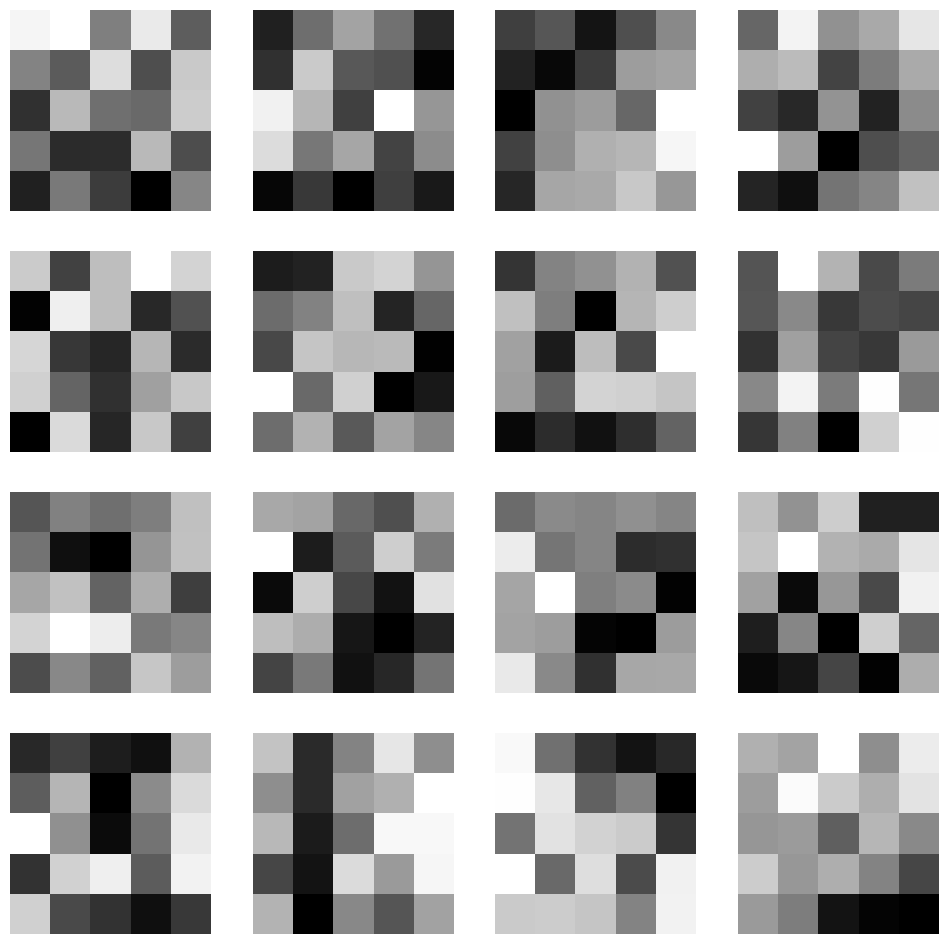

1311